In [1]:
import os
import logging
import momi
import sys
import matplotlib.pyplot as plt
from admixture_graph import *
from mcmc import *
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
from networkx.algorithms.cycles import find_cycle

os.chdir('..')
sys.path.append('scripts')
#logging.basicConfig(level=logging.DEBUG,
#                    filename="logs/admixture_graph_mcmc.log")

# Admixture graph demo

In [1]:
import matplotlib.pyplot as plt
import os
from scipy.stats import beta
os.chdir('/Users/chichun/Desktop/workspace/AdmixtreGraph2020')
import momi
import sys
sys.path.append('/Users/chichun/Desktop/workspace/AdmixtreGraph2020/scripts')
from admixture_graph import *
from mcmc import *
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
from networkx.algorithms.cycles import find_cycle
import logging
logging.basicConfig(level=logging.DEBUG,
                    filename="logs/tmp.log")

g = generate_easy_example_graph()
# nodes
ns = ['RT', 'A', 'B', 'C', 'D',
      '1', '2', '3', '4']

# set event time
ts = [1e5, 0, 0, 0, 0,
      6e4, 1e4, 2e3, 2e3]


t_event = dict()
for i, n in enumerate(ns):
    t_event[n] = ts[i]
g.set_event_time(t_event)

# set event type
types = ['merge'] * 9
types[7] = 'admixture'; types[8] = 'admixture'
types_dict = dict()
for i, n in enumerate(ns):
    types_dict[n] = types[i]
g.set_event_type(types_dict)

# set admixture_proportion
prop = {('3','4'): 0.3}
g.set_admixture_proportion(prop)

# set leaves attribute
demography = g.to_demography(print_events=True)

move from A to B at t = 10000.00
move from B to C at t = 60000.00
move from C to D at t = 100000.00
move from B to C at t = 2000.00 and proportion = 0.3


In [2]:
prefix = 'admixed_4pops.rep'
rep = '1'
sfs = f"data/sfs_{prefix}{rep}.gz"
sfs = momi.Sfs.load(f"data/sfs_{prefix}{rep}.gz")
demography.set_data(sfs)

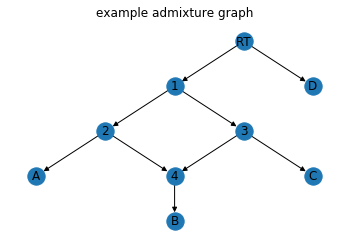

In [12]:
plot_graph(g, 'example admixture graph')

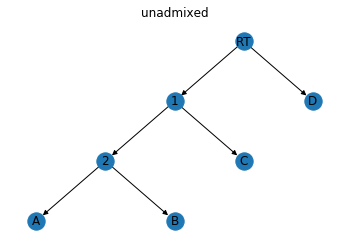

In [13]:
g_unadmixed = g.to_unadmixed_tree()
plot_graph(g_unadmixed, 'unadmixed')

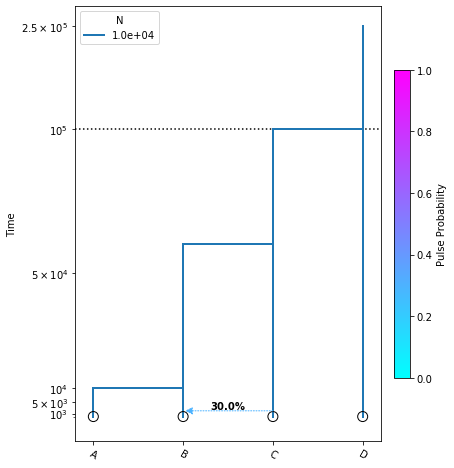

In [4]:
%matplotlib inline
yticks = [1e3, 5e3, 1e4, 5e4, 1e5, 2.5e5]

fig = momi.DemographyPlot(
    demography, ["A", "B", "C", "D"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1e5, pulse_color_bounds=(0,1))

move from A to B at t = 10000.00
move from B to C at t = 60000.00
move from C to D at t = 100000.00
move from D to C at t = 90782.24 and proportion = 0.3


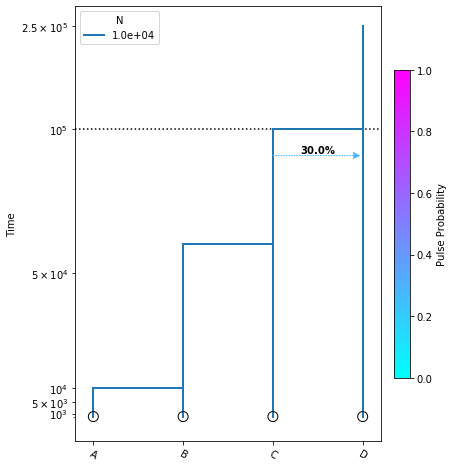

In [5]:
%matplotlib inline
random.seed(101)
g2, ratio = admixture_edge_proposal(g, print_output=False)
demography2 = g2.to_demography(print_events=True)
demography2.set_data(sfs)

yticks = [1e3, 5e3, 1e4, 5e4, 1e5, 2.5e5]
fig = momi.DemographyPlot(
    demography2, ["A", "B", "C", "D"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1e5, pulse_color_bounds=(0,1))

# Try MCMC

In [6]:
from collections import OrderedDict

def reject_proposal(trace):
    trace['theta'].append(trace['theta'][-1])
    trace['loglik'].append(trace['loglik'][-1])
    trace['topology'].append(trace['topology'][-1])
    trace['acceptance'].append('reject')

def accept_proposal(trace, theta, loglik, topology):
    trace['theta'].append(theta)
    trace['loglik'].append(loglik)
    trace['topology'].append(topology)
    trace['acceptance'].append('accept')

def event_time_proposal_randomwalk(graph):
    theta_current = OrderedDict(graph.get_events())
    admixture_edges = graph.get_admixture_edges()
    admixture_events = graph.get_admixture_events()
    admixture_nodes = [e[0] for e in admixture_events]
    proposal_sigmas = [(t[1]/20 + 1000) for t in graph.get_events()]

    times = dict()
    for i, e in enumerate(theta_current):
        mu = theta_current[e]
        times[e] = max(np.random.normal(mu, proposal_sigmas[i], 1)[0], 50)
    times_graph = times
    times_demo = times.copy()
    for e in admixture_edges:
        times_demo[f'{e[0]}_{e[1]}'] = times_demo[e[0]]
        times_graph[e[1]] = times_graph[e[0]]
        del times_demo[e[0]]
        del times_demo[e[1]]
    return times_graph, times_demo

def event_time_proposal_multiplicative(theta_current, rate = 10):
    ts = []
    scale = np.random.exponential(rate)
    shrink = np.random.binomial(1, 0.5)
    if shrink:
        scale = 1/scale
    for i, t in enumerate(theta_current):
        ts.append((t[0], scale * t[1]))
    return ts, scale

def admixture_proportion_proposal(graph):
    '''
    return proposed admixture fraction 
    and "log q(x'|x) - log q(x|x')"
    '''
    # beta proposal
    admixture_proportions = graph.get_admixture_proportions()
    proportions = dict()
    qs = 0
    for i, e in enumerate(admixture_proportions):
        mu = admixture_proportions[e]
        admixture_edge_name = f'{e[0]}_{e[1]}_proportion'
        a = mu * 30
        b = (1 - mu) * 30
        p = np.random.beta(a, b, 1)[0]
        proportions[admixture_edge_name] = p
        q_forward = beta.logpdf(p, a, b)
        a = p * 30
        b = (1 - p) * 30
        q_backward = beta.logpdf(mu, a, b)
        qs += q_backward - q_forward
    return proportions, qs

def update_theta(model, theta):
    model.set_params(theta)

In [7]:
print(demography.log_likelihood())
print(demography2.log_likelihood())

-60059.039873444235
-60367.17111525416


## No topolocial changes

In [8]:
def initialize_mcmc(admixture_graph, sfs, log_acceptance = True, rep = 3000):
    admixture_graph_tmp_holder = admixture_graph.copy()
    # convert networkx admixture graph to a momi demography model
    sfs = momi.Sfs.load(sfs)
    model = admixture_graph.to_demography()
    model.set_data(sfs)
    model_tmp_holder = model.copy()
    trace = {'theta': [], 'loglik': [], 
             'acceptance': [], 'topology': []}
    accept_proposal(
    trace = trace,
    theta = model.get_params(),
    loglik = model.log_likelihood(), 
    topology = admixture_graph.to_newick()
    )
    # metropolis-hasting
    for i in range(rep):
        if i % 10 <= 5:
            # propose new theta
            evenet_time_proposed_graph, event_time_proposed_demo = event_time_proposal_randomwalk(admixture_graph)
            admixture_graph_tmp_holder.set_event_time(evenet_time_proposed_graph)
            if admixture_graph_tmp_holder.is_event_order_feasible():
                # if the proposed theta is feasible update it in the holder momi model
                update_theta(model_tmp_holder, event_time_proposed_demo)
                loglik = model_tmp_holder.log_likelihood()
                a = min(np.exp(loglik - trace['loglik'][-1]), 1)
                if np.random.uniform() < a:
                    model = model_tmp_holder.copy()
                    admixture_graph = admixture_graph_tmp_holder.copy()
                    # accept and update current theta
                    accept_proposal(
                        trace = trace,
                        theta = model.get_params(),
                        loglik = loglik, 
                        topology = admixture_graph.to_newick()
                        )
                    result = 'accept'
                else:
                    reject_proposal(trace)
                    result = 'reject'
                if log_acceptance:
                    logging.debug(f'mcmc_{result} time_normalProposal a={a}')
            else:                                                           
                reject_proposal(trace)
                result = 'reject'
                if log_acceptance:
                    logging.debug(f'mcmc_{result} time_normalProposal infeasible')
        elif i % 10 <= 8:
            # propose new admixture proportion
            # To-Do: make sure copies are correct
            admixture_proportion_proposed, q = admixture_proportion_proposal(admixture_graph)
            update_theta(model_tmp_holder, admixture_proportion_proposed)
            loglik = model_tmp_holder.log_likelihood()
            a = min(np.exp(loglik - trace['loglik'][-1] + q), 1)
            if np.random.uniform() < a:
                model = model_tmp_holder.copy()
                admixture_graph = admixture_graph_tmp_holder.copy()
                # accept and update current theta
                accept_proposal(
                    trace = trace,
                    theta = model.get_params(),
                    loglik = loglik, 
                    topology = admixture_graph.to_newick()
                    )
                result = 'accept'
            else:
                reject_proposal(trace)
                result = 'reject'
            if log_acceptance:
                logging.debug(f'mcmc_{result} admixtureFraction_betaProposal a={a}')

        else:
            # propose new admixture position
            admixture_graph_tmp_holder, q = admixture_edge_proposal(admixture_graph)
            #print(admixture_graph_tmp_holder)
            model_tmp_holder = admixture_graph_tmp_holder.to_demography()
            model_tmp_holder.set_data(sfs)
            loglik = model_tmp_holder.log_likelihood()
            a = min(np.exp(loglik - trace['loglik'][-1] + q), 1)
            #print(f'loglik: {loglik}; q: {q}; a: {a}')
            if np.random.uniform() < a:
                model = model_tmp_holder.copy()
                admixture_graph = admixture_graph_tmp_holder.copy()
                # accept and update current theta
                accept_proposal(
                    trace = trace,
                    theta = model.get_params(),
                    loglik = loglik, 
                    topology = admixture_graph.to_newick()
                    )
                result = 'accept'
            else:
                reject_proposal(trace)
                result = 'reject'
            if log_acceptance:
                logging.debug(f'mcmc_{result} admixtureEdge_Proposal a={a}')

    return trace

In [9]:
prefix = 'admixed_4pops.rep'
rep = '1'
sfs = f"data/sfs_{prefix}{rep}.gz"
trace = initialize_mcmc(admixture_graph = g2, sfs = sfs, log_acceptance = True, rep = 5000)

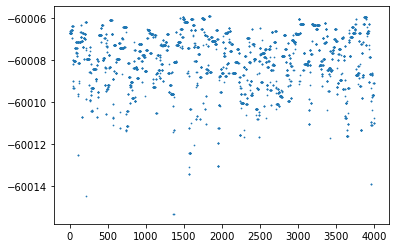

In [20]:
loglik = trace['loglik'][1000:]
plt.scatter(range(len(loglik)), loglik, s = .5)

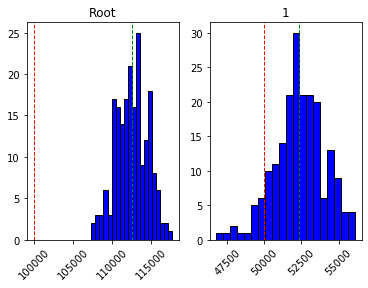

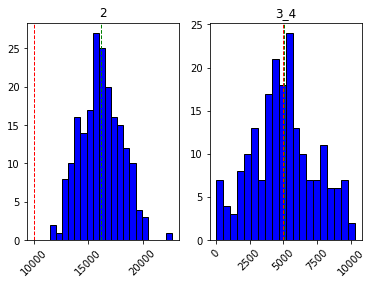

In [30]:
param = []
for i, d in enumerate(trace['theta']):
    param.append(d['RT'])
param = param[1000::20]
plt.subplot(1, 2, 1)
plt.hist(param, color = 'blue', edgecolor = 'black', bins = 20)
plt.xticks(rotation=45)
plt.title('Root')
plt.axvline(np.mean(param), color='green', linestyle='dashed', linewidth=1)
plt.axvline(1e5, color='red', linestyle='dashed', linewidth=1)

param = []
for i, d in enumerate(trace['theta']):
    param.append(d['1'])
param = param[1000::20]
plt.subplot(1, 2, 2)
plt.hist(param, color = 'blue', edgecolor = 'black', bins = 20)
plt.xticks(rotation=45)
plt.title('1')
plt.axvline(np.mean(param), color='green', linestyle='dashed', linewidth=1)
plt.axvline(5e4, color='red', linestyle='dashed', linewidth=1)
plt.show()

param = []
for i, d in enumerate(trace['theta']):
    param.append(d['2'])
param = param[1000::20]
plt.subplot(1, 2, 1)
plt.hist(param, color = 'blue', edgecolor = 'black', bins = 20)
plt.xticks(rotation=45)
plt.title('2')
plt.axvline(np.mean(param), color='green', linestyle='dashed', linewidth=1)
plt.axvline(1e4, color='red', linestyle='dashed', linewidth=1)

param = []
for i, d in enumerate(trace['theta']):
    param.append(d['3_4'])
param = param[1000::20]
plt.subplot(1, 2, 2)
plt.hist(param, color = 'blue', edgecolor = 'black', bins = 20)
plt.xticks(rotation=45)
plt.title('3_4')
plt.axvline(np.mean(param), color='green', linestyle='dashed', linewidth=1)
plt.axvline(5e3, color='red', linestyle='dashed', linewidth=1)
plt.show()


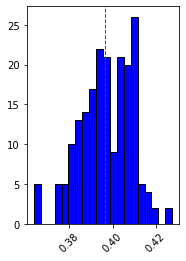

In [100]:
admixture_fraction = []
for i, d in enumerate(trace['theta']):
    admixture_fraction.append(d['3_4_proportion'])
admixture_fraction = admixture_fraction[1000::20]

plt.subplot(1, 2, 1)
plt.hist(admixture_fraction, color = 'blue', edgecolor = 'black', bins = 20)
plt.xticks(rotation=45)
plt.axvline(np.mean(admixture_fraction), color='green', linestyle='dashed', linewidth=1)

In [11]:
trace['topology'][995:]

[{'tree': '(D,((A,B),C))', 'admixture': ['(C)', '(B)']},
 {'tree': '(D,((A,B),C))', 'admixture': ['(C)', '(B)']},
 {'tree': '(D,((A,B),C))', 'admixture': ['(C)', '(B)']},
 {'tree': '(D,((A,B),C))', 'admixture': ['(C)', '(B)']},
 {'tree': '(D,((A,B),C))', 'admixture': ['(C)', '(B)']},
 {'tree': '(D,((A,B),C))', 'admixture': ['(C)', '(B)']}]